In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import path
import sys
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "AttentionGeometry":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(f">> current directory : {os.getcwd()}")

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache_attention')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
print(f">> cache path : {cache_path}")
print(f">> model path : {model_path}")
print(f">> dataset path : {dataset_path}")
print(f">> logs path : {log_path}")

# import the different modules
from src.attention_data_module.hatexplain import CLSTokenHateXPlainDM
from src.attention_data_module.esnli import CLSTokenESNLIDM
from src.attention_data_module.yelp_hat import CLSTokenYelpHat50DM, CLSTokenYelpHatDM
from src.pur_attention import AttitModel
from notebooks.attention_based.utils.ckp_config import *

# external librairies
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm

from modules.metrics.geometry import cosine_sim, effective_rank

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f">> device : {DEVICE}")

>> current directory : c:\Users\loicf\Documents\IRISA\AttentionGeometry
>> cache path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention
>> model path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\models
>> dataset path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\dataset
>> logs path : c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs
>> device : cuda


In [2]:
reg_params = [0, 0.0001, 0.001, 0.01, 0.1]

# HateXplain

In [3]:
sim_k_dict = {
    f"lambda={i}" : [] for i in reg_params
}
sim_v_dict = {
    f"lambda={i}" : [] for i in reg_params
}

dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=999
                 )

dm = CLSTokenHateXPlainDM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="hatexplain",
        num_class=dm.num_class,
        opt="adam"
)

for i in reg_params :

    ckp = os.path.join(log_path, "entropy_reg", "hatexplain", f"run=0_lentr={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "entropy_reg", "hatexplain", f"run0_lentr={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))

        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            sim_k = cosine_sim(k[0], padding_mask, normalize="").cpu().numpy()
            sim_v = cosine_sim(v[0], padding_mask, normalize="").cpu().numpy()

            # update dictionnaries
            sim_k_dict[f"lambda={i}"].append(sim_k)
            sim_v_dict[f"lambda={i}"].append(sim_v)

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

for k in sim_k_dict:
    sim_k_dict[k] = np.concatenate(sim_k_dict[k])
    sim_v_dict[k] = np.concatenate(sim_v_dict[k])
;

c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and prediction

  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0.0001\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predi

  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0.001\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predic

  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0.01\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predict

  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0.1\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predicti

  0%|          | 0/31 [00:00<?, ?it/s]

''

''

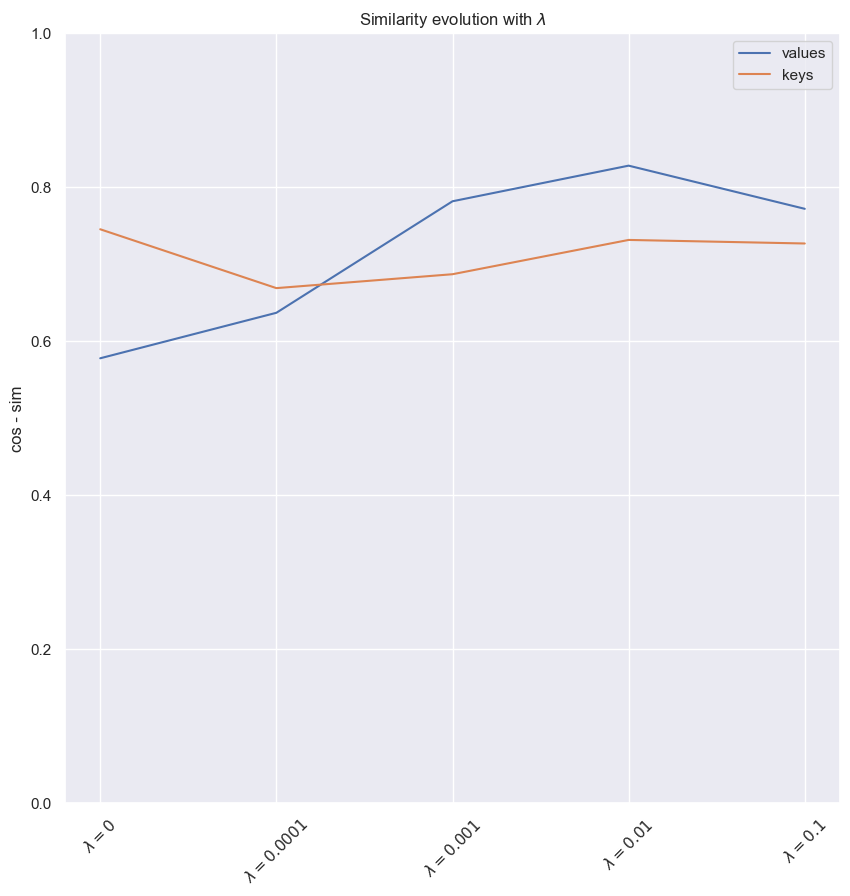

In [4]:
# the corresponding graphic
x_v, y_v, yerr_v = [], [], []
x_k, y_k, yerr_k = [], [], []

for idx, k in enumerate(sim_k_dict.keys()):
    x_v.append(idx)
    y_v.append(sim_v_dict[k].mean())
    yerr_v.append(sim_v_dict[k].std())

    x_k.append(idx)
    y_k.append(sim_k_dict[k].mean())
    yerr_k.append(1.96 * sim_k_dict[k].std())

figure = plt.figure(figsize=(10, 10))
plt.plot(x_v, y_v, label="values")
plt.plot(x_k, y_k, label="keys")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("cos - sim")
plt.title("Similarity evolution with $\lambda$")
#plt.xlabel("$\lambda$")
ax = plt.gca()
ax.set_xticks(list(range(len(sim_k_dict))))
labels = [f"$\lambda = {x}$" for x in reg_params]
ax.set_xticklabels(labels, rotation=45)
plt.savefig(os.path.join(cache_path, "fig", "reg_geometry", "reg_geometry_hatexplain.png"))
;

In [10]:
for i in np.round(y_v, 3):
    print( "{\\bf" ,i, "} &", end=" ")

{\bf 0.578 } & {\bf 0.637 } & {\bf 0.782 } & {\bf 0.828 } & {\bf 0.772 } & 

c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and prediction

  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([50, 300])


c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0.0001\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predi

  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([51, 300])


c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0.001\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predic

  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([50, 300])


c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0.01\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predict

  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([49, 300])


c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\pytorch_lightning\core\saving.py:348: RuntimeWarning: Missing Tags: c:\Users\loicf\Documents\IRISA\AttentionGeometry\.cache_attention\logs\entropy_reg\hatexplain\run0_lentr=0.1\hparams.yaml.
  rank_zero_warn(f"Missing Tags: {config_yaml}.", category=RuntimeWarning)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predicti

  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([55, 300])


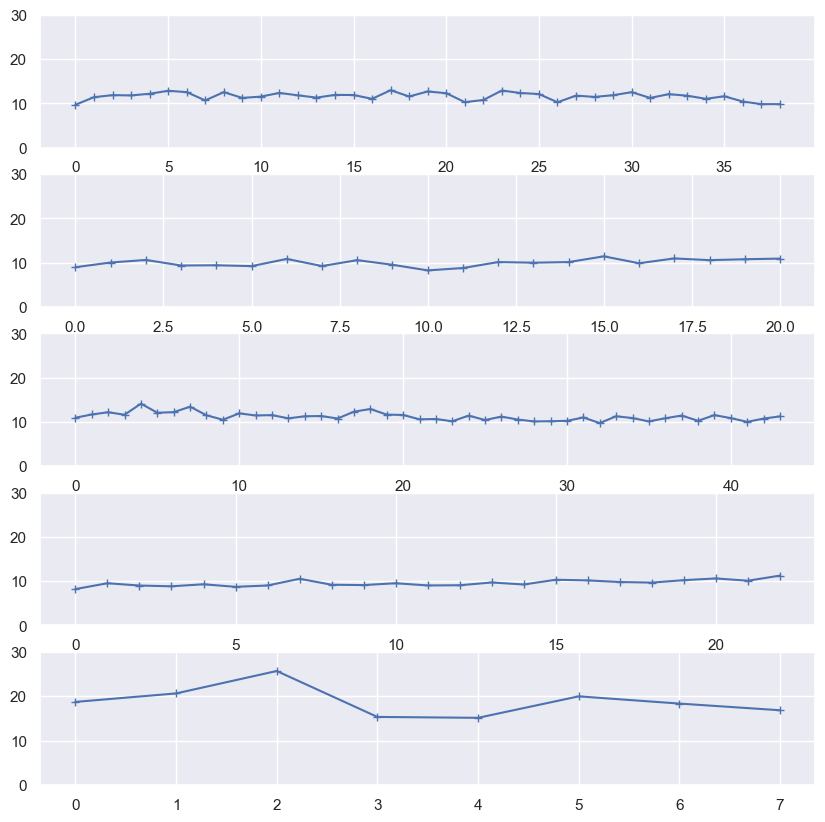

In [8]:
dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=999
                 )

dm = CLSTokenHateXPlainDM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
    cache_path=model_path,
    mode="exp",
    vocab=dm.vocab,
    lambda_entropy=0,
    lambda_supervise=0,
    lambda_lagrange=0,
    pretrained_vectors="glove.840B.300d",
    num_layers=1,
    num_heads=1,
    d_embedding=300,
    data="hatexplain",
    num_class=dm.num_class,
    opt="adam"
)

fig, axes = plt.subplots(5, 1, figsize=(10, 10))

for idx, i in enumerate(reg_params) :

    ckp = os.path.join(log_path, "entropy_reg", "hatexplain", f"run=0_lentr={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "entropy_reg", "hatexplain", f"run0_lentr={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))

        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            t = (~padding_mask[0, :]).sum()

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k = output["key_embeddings"]
            k_test = k[0][0]
            print(k_test.shape)
            temp = torch.matmul(k_test, torch.transpose(k_test, 0, 1))
            temp = temp.diagonal(offset=0).cpu().numpy()[:t]
            axes[idx].plot(list(range(len(temp))), np.sqrt(temp), "+-")
            axes[idx].set(ylim=(0, 30))
            break


# YelpHat

In [3]:
%%capture
sim_k_dict = {
    f"lambda={i}" : [] for i in reg_params
}
sim_v_dict = {
    f"lambda={i}" : [] for i in reg_params
}

dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=300
                 )

dm = CLSTokenYelpHat50DM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="yelphat50",
        num_class=dm.num_class,
        opt="adam"
)

for i in reg_params :

    ckp = os.path.join(log_path, "entropy_reg", "yelphat",f"run=0_lentr={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "entropy_reg", "yelphat",f"run=0_lentr={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))

        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            sim_k = cosine_sim(k[0], padding_mask, normalize="").cpu().numpy()
            sim_v = cosine_sim(v[0], padding_mask, normalize="").cpu().numpy()

            # update dictionnaries
            sim_k_dict[f"lambda={i}"].append(sim_k)
            sim_v_dict[f"lambda={i}"].append(sim_v)

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

for k in sim_k_dict:
    sim_k_dict[k] = np.concatenate(sim_k_dict[k])
    sim_v_dict[k] = np.concatenate(sim_v_dict[k])
;

''

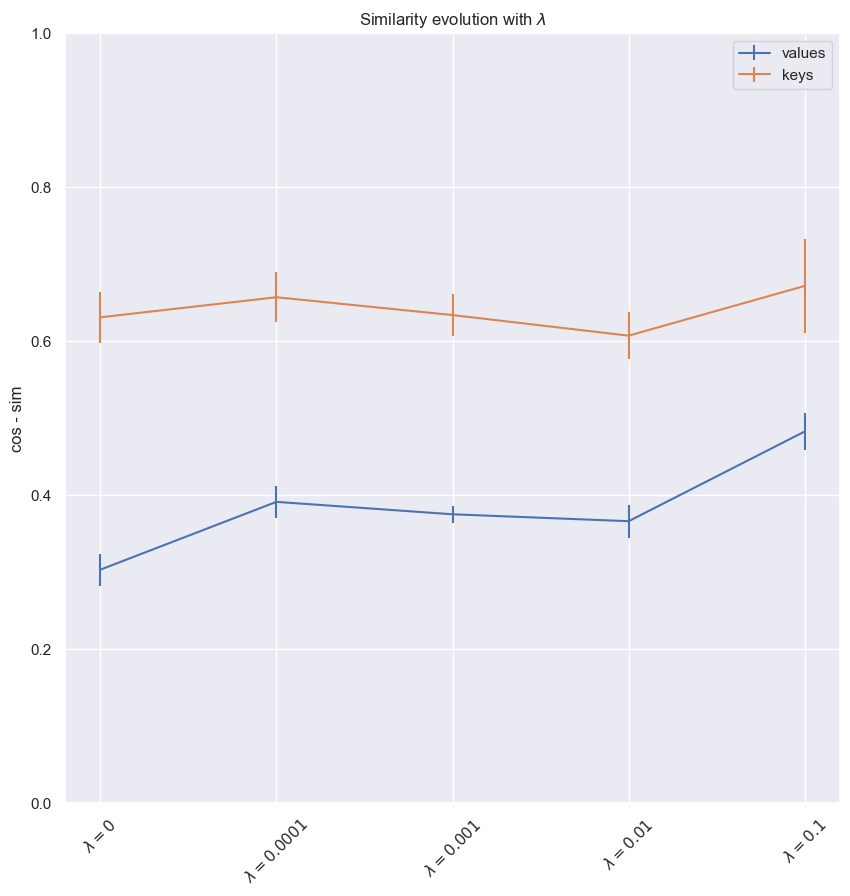

In [4]:
# the corresponding graphic
x_v, y_v, yerr_v = [], [], []
x_k, y_k, yerr_k = [], [], []

for idx, k in enumerate(sim_k_dict.keys()):
    x_v.append(idx)
    y_v.append(sim_v_dict[k].mean())
    yerr_v.append(sim_v_dict[k].std())

    x_k.append(idx)
    y_k.append(sim_k_dict[k].mean())
    yerr_k.append(1.96 * sim_k_dict[k].std())

figure = plt.figure(figsize=(10, 10))
plt.errorbar(x_v, y_v,  yerr=yerr_v, label="values")
plt.errorbar(x_k, y_k,  yerr=yerr_k, label="keys")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("cos - sim")
plt.title("Similarity evolution with $\lambda$")
#plt.xlabel("$\lambda$")
ax = plt.gca()
ax.set_xticks(list(range(len(sim_k_dict))))
labels = [f"$\lambda = {x}$" for x in reg_params]
ax.set_xticklabels(labels, rotation=45)
plt.savefig(os.path.join(cache_path, "fig", "reg_geometry", "reg_geometry_yelphat.png"))
;

In [5]:
for i in np.round(y_k, 3):
    print(i, "&", end=" ")

0.631 & 0.657 & 0.634 & 0.607 & 0.672 & 

In [6]:
for i in np.round(y_v, 3):
    print( "{\\bf" ,i, "} &", end=" ")

{\bf 0.303 } & {\bf 0.391 } & {\bf 0.375 } & {\bf 0.366 } & {\bf 0.483 } & 

# E-SNLI

In [11]:
%%capture
sim_k_dict = {
    f"lambda={i}" : [] for i in reg_params
}
sim_v_dict = {
    f"lambda={i}" : [] for i in reg_params
}

dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=999
                 )

dm = CLSTokenESNLIDM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="esnli",
        num_class=dm.num_class,
        opt="adam"
)

for i in reg_params :

    ckp = os.path.join(log_path, "entropy_reg", "esnli", f"run=0_lentr={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "entropy_reg", "esnli", f"run=0_lentr={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))

        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            sim_k = cosine_sim(k[0], padding_mask, normalize="").cpu().numpy()
            sim_v = cosine_sim(v[0], padding_mask, normalize="").cpu().numpy()

            # update dictionnaries
            sim_k_dict[f"lambda={i}"].append(sim_k)
            sim_v_dict[f"lambda={i}"].append(sim_v)

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

for k in sim_k_dict:
    sim_k_dict[k] = np.concatenate(sim_k_dict[k])
    sim_v_dict[k] = np.concatenate(sim_v_dict[k])
;

''

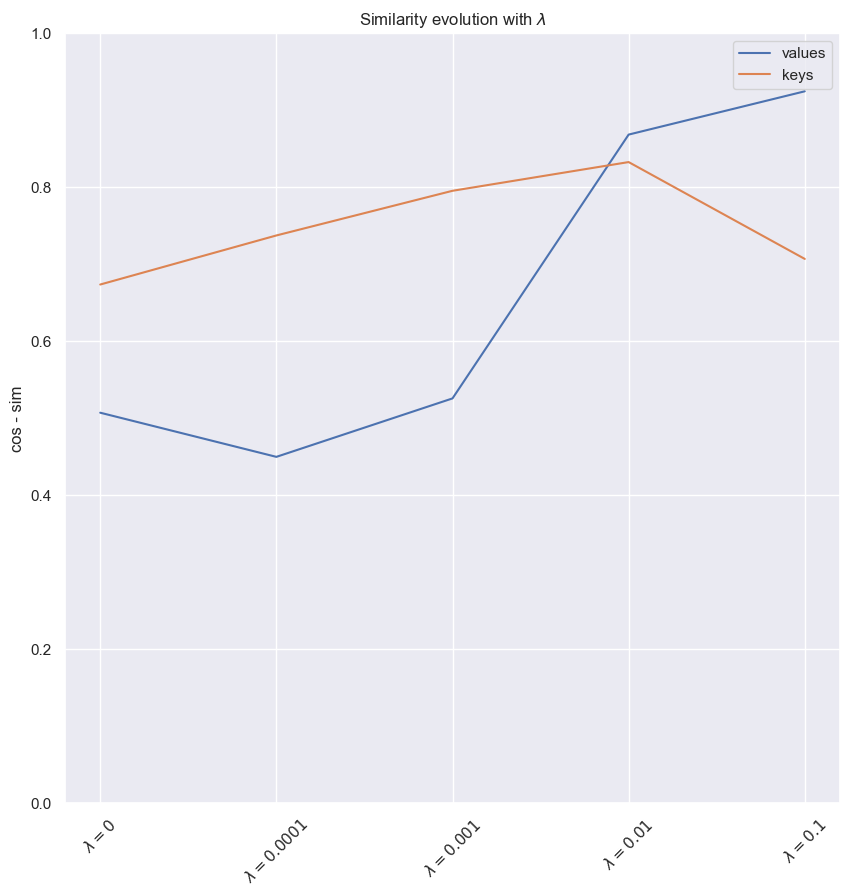

In [12]:
# the corresponding graphic
x_v, y_v, yerr_v = [], [], []
x_k, y_k, yerr_k = [], [], []

for idx, k in enumerate(sim_k_dict.keys()):
    x_v.append(idx)
    y_v.append(sim_v_dict[k].mean())
    yerr_v.append(sim_v_dict[k].std())

    x_k.append(idx)
    y_k.append(sim_k_dict[k].mean())
    yerr_k.append(1.96 * sim_k_dict[k].std())

figure = plt.figure(figsize=(10, 10))
plt.plot(x_v, y_v, label="values")
plt.plot(x_k, y_k, label="keys")
plt.ylim(0, 1)
plt.legend()
plt.ylabel("cos - sim")
plt.title("Similarity evolution with $\lambda$")
#plt.xlabel("$\lambda$")
ax = plt.gca()
ax.set_xticks(list(range(len(sim_k_dict))))
labels = [f"$\lambda = {x}$" for x in reg_params]
ax.set_xticklabels(labels, rotation=45)
plt.savefig(os.path.join(cache_path, "fig", "reg_geometry", "reg_geometry_esnli.png"))
;

In [13]:
for i in np.round(y_k, 3):
    print(i, "&", end=" ")

0.674 & 0.737 & 0.795 & 0.833 & 0.707 & 

In [14]:
for i in np.round(y_v, 3):
    print( "{\\bf" ,i, "} &", end=" ")

{\bf 0.507 } & {\bf 0.45 } & {\bf 0.526 } & {\bf 0.868 } & {\bf 0.925 } & 

c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([50, 300])


c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([50, 300])


c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([50, 300])


c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([50, 300])


c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
c:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/31 [00:00<?, ?it/s]

torch.Size([50, 300])


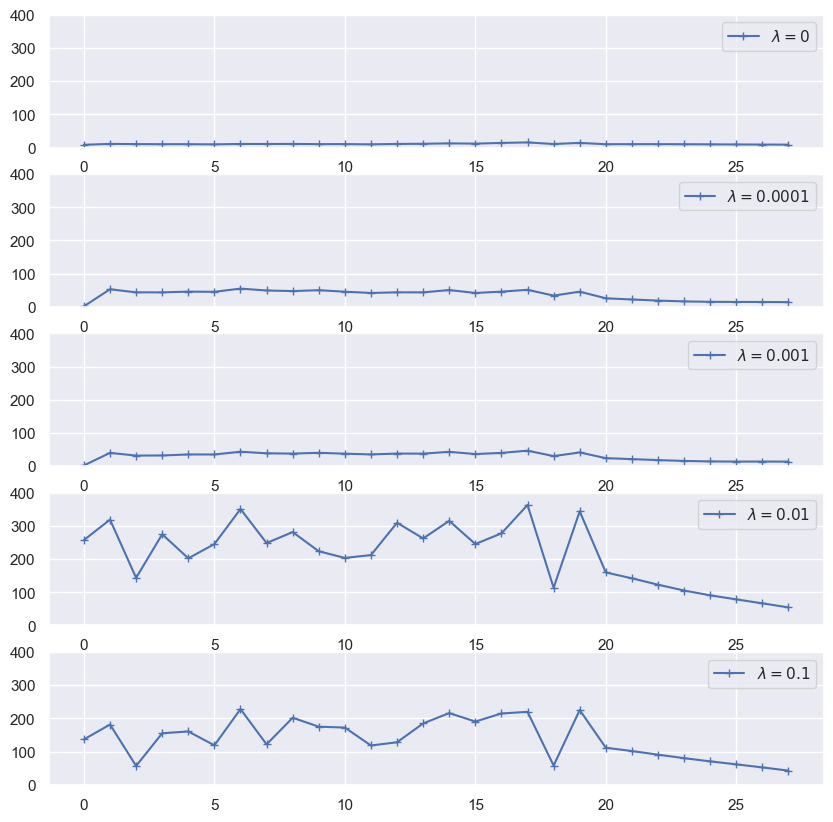

In [4]:
dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=999
                 )

dm = CLSTokenESNLIDM(**dm_kwargs)

dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader() # load the test dataset

spec_ids = torch.tensor(dm.vocab(["<cls>", "<pad>", "<unk>"]), device=DEVICE)

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="esnli",
        num_class=dm.num_class,
        opt="adam"
)

fig, axes = plt.subplots(5, 1, figsize=(10, 10))

for idx, i in enumerate(reg_params) :

    ckp = os.path.join(log_path, "entropy_reg", "esnli", f"run=0_lentr={i}", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "entropy_reg", "esnli", f"run=0_lentr={i}", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))

        for id_batch, batch in pbar:

            pbar.set_description("proceed the similarity metric")
            ids = batch["token_ids"].to(DEVICE)

            # PADDING
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            buff_mask = torch.isin(ids, spec_ids)
            embedding_padding = padding_mask.clone()
            embedding_padding[buff_mask] = 1.

            t = (~padding_mask[0, :]).sum()

            # OUTPUTS
            output = model(ids=ids, mask=padding_mask)

            k = output["key_embeddings"]
            k_test = k[0][0]
            print(k_test.shape)
            temp = torch.matmul(k_test, torch.transpose(k_test, 0, 1))
            temp = temp.diagonal(offset=0).cpu().numpy()[:t]
            axes[idx].plot(list(range(len(temp))), np.sqrt(temp), "+-", label=f"$\lambda={i}$")
            axes[idx].legend()
            axes[idx].set(ylim=(0, 400))
            break